In [1]:
import warnings
warnings.filterwarnings('ignore')
import os

In [2]:
# !pip install -U git+https://github.com/qubvel/efficientnet

In [3]:
__file__ = 'EfficientNet-B3-9.8.7-0123'
__version__ = 'v11'
fold = 0
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

In [4]:
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras_applications.resnext import ResNeXt50
from keras.applications.nasnet import NASNetLarge
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
import PIL
import time
import efficientnet.keras as efn 
from keras.utils import np_utils, Sequence

Using TensorFlow backend.


In [5]:
path_data = '../garbage_classify/train_data_v2/'
batch_size = 128
img_size = 300
img_width = img_size
img_height = img_size
random_seed = 201908

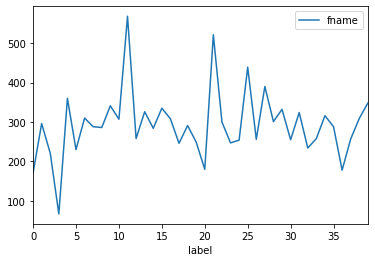

In [6]:
labels_train = pd.read_csv(f'../tmp/labels_train_{__version__}_fold{fold}.csv')
labels_valid = pd.read_csv(f'../tmp/labels_valid_{__version__}_fold{fold}.csv')
n_classess = labels_train.label.unique().shape[0]
labels_train.groupby(by='label').count().plot()

In [7]:
from data_gen_label import BaseSequence,smooth_labels

train_sequence = BaseSequence(path_data + labels_train['fname'].values,
                              np_utils.to_categorical(labels_train.label.values, n_classess),
                              batch_size,
                              [img_size, img_size],
                              use=True,
                              preprocess_input=efn.preprocess_input)

validation_sequence = BaseSequence(path_data + labels_valid['fname'].values,
                                   np_utils.to_categorical(labels_valid.label.values, n_classess),
                                   batch_size*8,
                                   [img_size, img_size],
                                   use=False,
                                   preprocess_input=efn.preprocess_input)

len(train_sequence),len(validation_sequence)

(92, 3)

In [8]:
# labels_train.label = labels_train.label.apply(lambda x: f'{x:02d}')
# labels_valid.label = labels_valid.label.apply(lambda x: f'{x:02d}')
# labels_train['label_bin'].values = keras.utils.np_utils.to_categorical(
#     labels_train.label, n_classess)

({0: 1.714766081871345,
  1: 0.990625,
  2: 1.3268099547511312,
  3: 4.376492537313433,
  4: 0.8145138888888889,
  5: 1.274891304347826,
  6: 0.9458870967741936,
  7: 1.0181423611111111,
  8: 1.0252622377622378,
  9: 0.8598973607038123,
  10: 0.9551302931596091,
  11: 0.5162411971830986,
  12: 1.136531007751938,
  13: 0.8994631901840491,
  14: 1.0324823943661972,
  15: 0.8752985074626866,
  16: 0.9520292207792208,
  17: 1.191971544715447,
  18: 1.0076460481099656,
  19: 1.1776104417670683,
  20: 1.6290277777777777,
  21: 0.5628119001919386,
  22: 0.9774166666666667,
  23: 1.1871457489878543,
  24: 1.1544291338582677,
  25: 0.6679384965831435,
  26: 1.14541015625,
  27: 0.7518589743589743,
  28: 0.9741694352159468,
  29: 0.8832078313253012,
  30: 1.1499019607843137,
  31: 0.9050154320987654,
  32: 1.2530982905982906,
  33: 1.136531007751938,
  34: 0.9279272151898734,
  35: 1.0181423611111111,
  36: 1.6473314606741574,
  37: 1.140953307392996,
  38: 0.9489482200647249,
  39: 0.8426005747

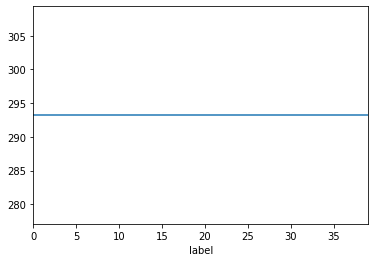

In [9]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(labels_train.label), labels_train.label)
d_class_weights = dict(enumerate(class_weights))
d_class_weights,(labels_train.groupby(by='label').count()['fname'] * class_weights).plot()

In [10]:
base_model = efn.EfficientNetB3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3),pooling='avg')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
# for i, layer in enumerate(base_model.layers):
#     print(i, layer.name)
base_model.input_shape

(None, 300, 300, 3)

In [12]:
# 锁定block 1 ~ 4
for layer in base_model.layers[:185]:
    layer.trainable=False

In [13]:
x = base_model.output

x = Dense(128)(x)
x = BatchNormalization()(x)
x=Dropout(0.5)(x)

DENSE_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 1. / 3.,
        'mode': 'fan_out',
        'distribution': 'uniform'
    }
}
predictions = Dense(n_classess, activation='softmax',kernel_initializer=DENSE_KERNEL_INITIALIZER)(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 150, 150, 40) 1080        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 150, 150, 40) 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 150, 150, 40) 0           stem_bn[0][0]                    
__________________________________________________________________________________________________
block1a_dw

In [14]:
from keras.utils import multi_gpu_model
model = multi_gpu_model(model,gpus=4)

with open(f'../tmp/model_{__file__}.json','w') as f:
    model_json = model.to_json()
    f.write(model_json)

In [15]:
# from warmup_cosine_decay_scheduler import WarmUpCosineDecayScheduler
# sample_count = len(train_sequence) * batch_size
# epochs = 100
# warmup_epoch = 5
# total_steps = int(epochs * sample_count / batch_size)
# warmup_steps = int(warmup_epoch * sample_count / batch_size)

# warm_up_lr = WarmUpCosineDecayScheduler(learning_rate_base=1e-4,
#                                         total_steps=total_steps,
#                                         warmup_learning_rate=0,
#                                         warmup_steps=warmup_steps,
#                                         hold_base_rate_steps=1,
#                                         )

In [16]:
ckpt = ModelCheckpoint('../tmp/ckpt-'+__file__+'-Epoch_{epoch:03d}-acc_{acc:.5f}-val_acc_{val_acc:.5f}.h5', save_best_only=True, monitor='val_acc',verbose=1)

estop = EarlyStopping(monitor='val_acc', min_delta=1e-7,verbose=1, patience=20)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=1e-5,verbose=1)

csv_logger = CSVLogger(f'../tmp/training_{__file__}.log',append=True)

In [ ]:
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(
    train_sequence,
    # steps_per_epoch=100,
#     steps_per_epoch=len(train_sequence),
    epochs=100,
    class_weight=d_class_weights,
    callbacks=[ckpt, estop,reduce_lr,csv_logger],
    validation_data=validation_sequence,
    # validation_steps=1,
#     validation_steps=valid_g.n // batch_size
    workers=32,
    use_multiprocessing=True,
    shuffle=True
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
92/92 [==============================] - 158s 2s/step - loss: 3.0651 - acc: 0.2341 - val_loss: 1.4667 - val_acc: 0.6269

Epoch 00001: val_acc improved from -inf to 0.62695, saving model to ../tmp/ckpt-EfficientNet-B3-9.8.7-0123-Epoch_001-acc_0.23412-val_acc_0.62695.h5
Epoch 2/100
92/92 [==============================] - 93s 1s/step - loss: 1.6043 - acc: 0.5594 - val_loss: 0.9363 - val_acc: 0.7529

Epoch 00002: val_acc improved from 0.62695 to 0.75288, saving model to ../tmp/ckpt-EfficientNet-B3-9.8.7-0123-Epoch_002-acc_0.55964-val_acc_0.75288.h5
Epoch 3/100
92/92 [==============================] - 95s 1s/step - loss: 1.1717 - acc: 0.6731 - val_loss: 0.7570 - val_acc: 0.7982

Epoch 00003: val_acc improved from 0.75288 to 0.79824, saving model to ../tmp/ckpt-EfficientNet-B3-9.8.7-0123-Epoch_003-acc_0.67363-val_acc_0.79824.h5
Epoch 4/100
92/92 [==============================] - 99s 1s/step - loss: 0.9431 - acc: 0.7394 - val_loss:

In [ ]:
!ls